<a href="https://colab.research.google.com/github/olgOk/Mottonen-State-Preparation-on-Qiskit/blob/main/MottonenStatePrep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# istall qiskit 
!python3 -m pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.7 MB 5.3 MB/s 
     |████████████████████████████████| 19.2 MB 59.1 MB/s 
     |████████████████████████████████| 240 kB 54.3 MB/s 
     |████████████████████████████████| 55 kB 3.7 MB/s 
     |████████████████████████████████| 112 kB 45.6 MB/s 
     |████████████████████████████████| 49 kB 5.8 MB/s 
     |████████████████████████████████| 49 kB 6.5 MB/s 
     |████████████████████████████████| 943 kB 51.8 MB/s 
     |████████████████████████████████| 37.5 MB 44 kB/s 
     |████████████████████████████████| 4.0 MB 34.1 MB/s 
     |████████████████████████████████| 1.9 MB 2.7 MB/s 
     |████████████████████████████████| 112 kB 74.6 MB/s 
  Created wheel for qiskit: filename=qiskit-0.38.0-py3-none-any.whl size=12147 sha256=7e1c4564c7566378bc9aa8a9ee7324cd0444b43d98fa6bc0f2bffda84afdd22b
  Stored in directory: /root/.cache/pip/wheels/0b/30/78/04c91b

In [2]:
#imports
import numpy as np
from qiskit import QuantumCircuit
# from qiskit.providers.aer import QasmSimulator

# from qiskit.visualization import plot_histogram, plot_bloch_vector
from typing import Tuple, Any
import math
import cmath

# Mottonen State Preparation in Qiskit

Mottonen State is a quantum state prepared through uniformly controlled rotations. A uniformly controlled rotation with $l$ controll nodes and $n$-th target qubit can be expressed as the composotion of all possible controlled rotations on the target qubit as described in [Mottonen et. al., 2008]. In this work, I used the basic quantum gates such as $CNOT, R_y(\alpha)$, and $R_z(\alpha)$ avaliable in IBM Qiskit to decompose a uniformly controlled rotations.

For example, if a uniformly controlled rotation has 2 controlled nodes, then its decomposition is two $CNOT$ gates and a rotation gate $R_a(\alpha)$ applied on the target qubit. 

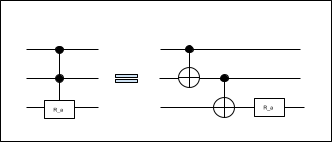

where $R_a(\alpha)$ is the one qubit rotation around the axis $a$ on the angle $\alpha$. Using IBM Qiskit, these gates are $R_y(\alpha)$ and $R_z(\alpha)$.


The idea behind the Mottonen State preparation algorithm is to apply a sequence of gates such that this sequense transforms an input state $|a>$ to the other state $|b>$.
The algorithm of preparing the Mottonen state consists of three core steps.
First, one has to equilize the phases usign the cascade of uniformly controlled $z$-rotations. Secondly, one has to apply uniformly controlled $y$-rotations to to bring the input state to some fixed state $|e>$. Finally, one has to prepare the other circuit that transforms the fixed state $|e>$ in to the desired state $|b>$. The fixed state $|e>$ can be any of the basis vector.

## Gray Code

First, I used Gray Code [1] as described in [Mottonen et. al., 2008] to generate all posible controlled rotations on a qubit. The algorithm for generating Gray Code representation consists of 1)finding binary of a numbers from $1$ to $n$, and 2) converting it to a string representation.  

In [3]:
def get_gray_code(n:int)->np.array:
  """
    Generates Gray code representation of a number using logical bitwise operations.
    Gray code representation is used to get the position of control nodes. 

    Args:
      n: number to be represented as binary. 
    
    Returns:
      gray_binary: (np.array of strings) binary reflecting Gray code representation.
  """

  gray_list = []
  
  for i in range(1 << n):
    gray_binary = bin(i ^ (i >> 1))[2::]
    gray_binary = gray_binary.zfill(n)
    gray_list.append(gray_binary)

  return np.asarray(gray_list)

# unmute for testing 
# get_gray_code(3)

## Computing Phases

Secondly, I computed the phases $\omega_i$ required to apply controlled $z$-rotations ($R_z$) to render the vector real up to a global phase.

In [4]:
def get_phases(state: np.array) -> np.array:
  """
    Calculates the phases omega_i used in transforming the given state vector 
    to the first basis vector.

    Args:  
      state: (array-like), the state vector which is transformed to the first basis vector.
    Returns: 
      omega_phases: a np.array of floats, the phase angles for the given state vector.
  """

  omega_phases = np.empty(len(state), dtype=float)

  for st in range(len(state)):
    omega_phases[st] = cmath.phase(state[st])

  return omega_phases
  
# unmute for testing
# get_phases(state)

## Obtaining $\theta_i$ Angles from $\alpha_i$ Angles 

Thirdly, I converted angles $\alpha_i$ from the input state to new angles $\theta_i$ used in the single qubit gate rotations $R_z$ and $R_y$ as given in the equation 3 in [Mottonen et. al., 2008]:

\begin{align}
        \begin{pmatrix}
        \ \theta_1  \\
        \ ... \\
        \ \theta_l
        \end{pmatrix} = M_{ij} \begin{pmatrix}
        \ \alpha_1  \\
        \ ... \\
        \ \alpha_l
        \end{pmatrix}.
    \end{align}

where $l = 2^k$, and the entries of the matrix $M_{ij}$ are derived as

\begin{align}
  M_{ij} = 2^{-k}(-1)^{ b_{j-1} ̇g_{i-1}}
\end{align}

where $b_{j_1}$ and $g_{i_1}$ are the binary code of the integer $(j-1)$ and reflected Gray Code of the integer $(i-1)$, respectively [2]. The number $k$ is the number of controll nodes. 

The bitwise dot product of $b_{j_1}$ and $g_{i_1}$ is described in [4].



In [5]:
def numberOfSetBits(n):
     n = n - ((n >> 1) & 0x55555555);
     n = (n & 0x33333333) + ((n >> 2) & 0x33333333);
     return (((n + (n >> 4)) & 0x0F0F0F0F) * 0x01010101) >> 24;


def get_m_matrix_entry(i:int, j:int, k:int)-> int:
  """
    The matrix entries defined as M_ij = 2^(-k) * (-1)^(b_(j-1) * g_(i-1))

    Args:
      i: (int), the row number.
      j: (int), the colunm number
      k: (int), number of control nodes.
    Returns:
      m_ij: (int), the entry of the M matrix in i-th row and j-th column.
  """

  bitwise_dot_product = numberOfSetBits((i) & (j)) % 2
  m_ij = (2 ** (-k)) * (-1) ** bitwise_dot_product
  
  return m_ij

# for testing
# get_m_matrix_entry(2, 2, 2)

## Calculating Angles for $R_y$ Gates

The angles $\alpha_{j,k}$ for the $R_y$ rotation gate are calcualetd through the magnitudes of the input vector as defined in the expression of the equation 8 in [Mottonen et. al.]

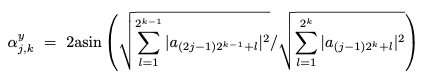

where $j=1, 2, . . . , 2^{n−k}$ and $k=1, 2, . . . , n$. $n$ represents the number of qubits in a quantum circuit.

In [6]:
def alpha_y(state:np.array, n:int, k:int) -> float:
  """
  Calculates the agles alpha_i sunbited to the R_y gate.
  Args:
    state: (array-like), the state of the input vector to be transformed.
    n: (int), the number of qubits in circuit.
    k: (int), the number of controll nodes.
  Returns:
    alpha :(float), the value of rotation angle (r_y quatum gate).
  """
  
  magnitude = [abs(st) for st in state]
  magnitude = np.asarray(magnitude)

  denominator = 0
  numerator = 0
  for j in range(2 ** (n - k)):
    # construct denominator 
    for l in range(2 ** k):
      index = (j) * (2 ** k) + l
      denominator += (magnitude[index]) ** 2 
  
    # construct numerator
    for l in range(2 ** (k - 1)):
      index = (2 * (j+1) - 1) * (2 ** (k - 1)) + l 
      numerator += (magnitude[index]) ** 2 

  return 2 * math.asin(math.sqrt(numerator / denominator))

# for testing 
# state = np.array([2, 2j, 6, 6j]) 
# alpha_y(state, 2, 2)

## Calculating Angles for $R_z$ Gates

The angles $\alpha_{j,k}$ for the $R_z$ rotation gate are calcualetd through the phases $\omega_i$ of the input vector and defined in the expression of the equation 5 in [Mottonen et. al.]:

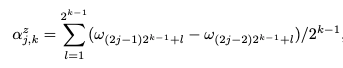


where $j=1, 2, . . . , 2^{n−k}$ and $k=1, 2, . . . , n$. $n$ represents the number of qubits in a quantum circuit.

In [7]:
def alpha_z(omega_phases:np.array, n:int, k:int) -> float:
  """
  Calcualtes angles alpha_i submitted tot he rotation gate R_z.
  Args:
    omega_phases: (np.array), phases of the input vector.
    n: (int), the number of qubits in circuit.
    k: (int), the number of the control nodes. 
  Returns:
    alpha_z: (float), the value of rotation angle (r_z quatum gate).
  """

  numerator = 0
  for j in range(1, 2 ** (n - k) + 1):
    # construct denominator 
    for l in range(1, 2 ** (k-1) + 1):
      expression1 = (2 * (j) - 1) * (2 ** (k - 1)) + l - 1
      expression2 = (2 * (j) - 2) * (2 ** (k - 1)) + l - 1
      numerator += (omega_phases[expression1] - omega_phases[expression2])

  return numerator / 2 ** (k - 1)

# for testing
# phases = get_phases(state)
# alpha_z(phases, 2,1)

## Construct the Unitary Gates Sequence

The function `apply_gate_sequence()` aplies the sequence of the $CNOT$, $R_y$, and $R_z$ gates. The contoll nodes are determined via the Gray code representation. The agles $\alpha_z$ and $\alpha_y$ are transformed to angles $\theta$ using the defenition of the matrix $M_{ij}$.

In [8]:
def apply_gate_sequence(q_circuit, gate, angle:np.array, k:int, target:int)->None:
  """
  Applies the sequence of quantum gates based the Gray code representation for 
  the controll nodes.

  Args:
    q_circuit: an object of the class 'qiskit.circuit.quantumcircuit.QuantumCircuit. 
              A gate is to be applied on the q_circuit.
    gate: a method of the  class 'qiskit.circuit.quantumcircuit.QuantumCircuit
           a qiskit quantum gate object to be applied on the quantum circuit.
    angle: (np.array) angle to be transformed using the M_ij matrix.
    k: (int), a number of controll qubits.
    target: (int), a node of the target qubit.
  Returns:
    None.
  """

  # compute theta angles as discribed in eq. 3
  size = len(angle)
  matrix_M = np.zeros(shape=(size, size))

  for i in range(size):
    for j in range(size):
      matrix_M[i][j] = get_m_matrix_entry(i, j, k)

  theta_angles = np.dot(matrix_M, np.transpose(angle))
  theta_angles = np.transpose(theta_angles)

  gray_code = get_gray_code(k)

  control_gates = []
  for i in range(len(gray_code)):
    # representing Gray code binaries as regular binaries through XOR operator
    control = int(gray_code[i], 2) ^ int(gray_code[(i+1) % len(gray_code)], 2)
    control = int(np.log2(control))
    control_gates.append(control)


  if len(control_gates) == 2:
    q_circuit.cx(0, 1)
    if gate == 'ry':
        q_circuit.ry(theta_angles[0], 1)
    elif gate == 'rz':
        q_circuit.rz(theta_angles[0], 1)

  for i in range(len(control_gates)-2, 0, -1):
    # aply cx gates
    j = control_gates[i]
    while j != target:
      q_circuit.cx(j, j+1)
      j += 1

    # apply rotation gates
    if gate == 'ry':
        q_circuit.ry(theta_angles[i], target)
    elif gate == 'rz':
        q_circuit.rz(theta_angles[i], target)
    

## Mottonen State Preparation Function
 
 The `state_prep()` function prepares the Mottonen State of an input vector. The input vector is normalized firstly. The rotation angles $\alpha_y$ and $\alpha_z$ for the $R_y$ and $R_z$ quantum gates are calculated based on the magnitude and phase of the input vector. The output of the function is the Mottonen State prepared and equals to the normalized initial state up to a global phase which is not observable. The second curcuit prepared is the inverse of the initial.


In [9]:
def state_prep(input_vector):
  """
  Prepares the Mottonen State as descibed in the research paper by Mottonen et. al.
  The circuit of the state decompisition is printed.
  Note, that the Mottonen State is equal to the final state. The difference 
  between final state and the initial state is in a global phase which is not 
  observable. The state returned is a normalized version of the initial state.

  Args:
   input_vector: (np.array), array that contains values of the size 2^n to be 
                  prepared as Mottonen State.
  Returns:
    mottonen_state: the Mottonen state preparation of the input_vector.
    sheme of circuit: a class of 'qiskit.visualization.text.TextDrawing', the
                  graphical representation of the quantum circuit decomposed.
  """

  # normalize state
  state = input_vector / np.linalg.norm(input_vector)
 
  # get number of qubits for circuit based on the lenght of the state
  num_qubits = int(math.log2(len(state)))

  qc = QuantumCircuit(num_qubits)

  phases = get_phases(state)
  angles_alpha_z = [alpha_z(phases, num_qubits, k) for k in range(1, num_qubits+1)]
  angles_alpha_y = [alpha_y(state, num_qubits, k) for k in range(1, num_qubits+1)]

  # sequence of control rz gates
  for control in range(num_qubits-1,  0, -1):
      apply_gate_sequence(qc, 'rz', angles_alpha_z, control, control)
  qc.rz(angles_alpha_z[num_qubits-1], num_qubits-1)

  # sequence of control ry gates
  for control in range(num_qubits-1,  0, -1):
      apply_gate_sequence(qc, 'ry', angles_alpha_y, control, control)
  qc.ry(angles_alpha_y[num_qubits-1], num_qubits-1)

  # inverse the circuit to prepare the second circuit.
  qc_inv = qc.inverse()
  qc = qc.compose(qc_inv)

  return state, qc.draw()

In [10]:
input_states =[[1-3j, 5+10j], [1-2j, 3+1j, 4j, 5], [1-3j, 5+10j, 1-2j, 3+1j, 7j, 3, -3-6j, -10+1j]]

for state in input_states:
  state_prepared, circuit_representation = state_prep(np.asarray(state))
  print("Initial state is \n {}". format(state))
  print("Mottonen state prepared is \n {} .". format(state_prepared))
  print("Quantum circuit: \n", circuit_representation)
  print("=========================")

Initial state is 
 [(1-3j), (5+10j)]
Mottonen state prepared is 
 [0.0860663 -0.25819889j 0.43033148+0.86066297j] .
Quantum circuit: 
    ┌──────────┐┌────────────┐┌─────────────┐┌───────────┐
q: ┤ Rz(3π/4) ├┤ Ry(2.5903) ├┤ Ry(-2.5903) ├┤ Rz(-3π/4) ├
   └──────────┘└────────────┘└─────────────┘└───────────┘
Initial state is 
 [(1-2j), (3+1j), 4j, 5]
Mottonen state prepared is 
 [0.13363062-0.26726124j 0.40089186+0.13363062j 0.        +0.53452248j
 0.6681531 +0.j        ] .
Quantum circuit: 
                                                                      »
q_0: ──■──────────────────────────────■──────────────────────────────»
     ┌─┴─┐┌────────────┐┌──────────┐┌─┴─┐┌────────────┐┌────────────┐»
q_1: ┤ X ├┤ Rz(0.5181) ├┤ Rz(3π/8) ├┤ X ├┤ Ry(1.9386) ├┤ Ry(2.0536) ├»
     └───┘└────────────┘└──────────┘└───┘└────────────┘└────────────┘»
«                                                                         
«q_0: ────────────────────────────────■────────────────────────────────■─

## References

1. [Gray Code. Wikipedia](https://en.wikipedia.org/wiki/Gray_code).
2. [Bitwise Inner Product and Orthogonality. StackExchange](https://math.stackexchange.com/questions/2884507/bitwise-inner-product-and-orthogonality)
3. [Mottonen, M. et. al., *Transformation of Quantum States Using Uniformly Controlled Rotations*, 2008](https://arxiv.org/pdf/quant-ph/0407010.pdf).
4. [Mottonen, M. et. al., *Quantum Circuit for General Multi-Qubit Gates*, 2008.](https://arxiv.org/pdf/quant-ph/0404089.pdf).


*Note to the QOSF Cometee.* Due to a tech issue, I have received an invitation to complete a technical assessmnet one week later. Therefore, the official deadline was extended by a week and the QOSF mentors were notified about this issue. 